In [1]:
import pandas as pd
import numpy as np
import zipfile
import os

def is_colab():
    return 'COLAB_GPU' in os.environ
zip_file = f"MINDlarge_train.zip"
valid_zip_file = f"MINDlarge_test.zip"
data_dir = 'dataset/train/'  # Adjust path as necessary
valid_data_dir = 'dataset/valid/'  # Adjust path as necessary
if is_colab():
    print("Running on Google colab")
    data_dir = '/content/train/'
    valid_data_dir = '/content/valid/'
#data_dir = 'dataset/small/train/'  # Adjust path as necessary
#zip_file = f"MINDsmall_train.zip"
zip_file_path = f"{data_dir}{zip_file}"
valid_zip_file_path = f"{valid_data_dir}{valid_zip_file}"
# Get the directory where the zip file is located
output_folder = os.path.dirname(zip_file_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
if is_colab():
  valid_output_folder = os.path.dirname(valid_zip_file_path)
  with zipfile.ZipFile(valid_zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(os.path.dirname(valid_output_folder))
news_file = 'news.tsv'
behaviors_file = 'behaviors.tsv'

# Load news data
news_path = os.path.join(data_dir, news_file)
news_df = pd.read_csv(
    news_path,
    sep='\t',
    names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'],
    index_col=False
)

print("Loaded news data:")
print(news_df.head())

# Load behaviors data
behaviors_path = os.path.join(data_dir, behaviors_file)
behaviors_df = pd.read_csv(
    behaviors_path,
    sep='\t',
    names=['ImpressionID', 'UserID', 'Time', 'HistoryText', 'Impressions'],
    index_col=False
)

print("\nLoaded behaviors data:")
print(behaviors_df.head())
# Handle missing 'HistoryText' by replacing NaN with empty string
behaviors_df['HistoryText'] = behaviors_df['HistoryText'].fillna('')

# Create a NewsID to Category mapping
newsid_to_category = news_df.set_index('NewsID')['Category'].to_dict()

# Function to extract categories from HistoryText
def extract_categories(history_text):
    if not history_text:
        return []
    news_ids = history_text.split(' ')
    categories = [newsid_to_category.get(news_id, 'Unknown') for news_id in news_ids]
    return categories

# Apply the function to extract categories
behaviors_df['HistoryCategories'] = behaviors_df['HistoryText'].apply(extract_categories)

print("\nSample HistoryCategories:")
print(behaviors_df[['UserID', 'HistoryCategories']].head())
from collections import defaultdict

# Initialize a dictionary to hold category counts per user
user_category_counts = defaultdict(lambda: defaultdict(int))

# Populate the dictionary
for idx, row in behaviors_df.iterrows():
    user_id = row['UserID']
    categories = row['HistoryCategories']
    for category in categories:
        user_category_counts[user_id][category] += 1

# Convert the dictionary to a DataFrame
user_category_profiles = pd.DataFrame(user_category_counts).T.fillna(0)

# Optionally, rename columns to indicate category
user_category_profiles.columns = [f'Category_{cat}' for cat in user_category_profiles.columns]

print("\nCreated user_category_profiles:")
print(user_category_profiles.head())
print(f"\nShape of user_category_profiles: {user_category_profiles.shape}")
# Handle missing 'HistoryText' by replacing NaN with empty string
behaviors_df['HistoryText'] = behaviors_df['HistoryText'].fillna('')

# Create a NewsID to Category mapping
newsid_to_category = news_df.set_index('NewsID')['Category'].to_dict()

# Get all unique UserIDs from behaviors_df
unique_user_ids = behaviors_df['UserID'].unique()

# Function to extract categories from HistoryText
def extract_categories(history_text):
    if not history_text:
        return []
    news_ids = history_text.split(' ')
    categories = [newsid_to_category.get(news_id, 'Unknown') for news_id in news_ids]
    return categories

# Apply the function to extract categories
behaviors_df['HistoryCategories'] = behaviors_df['HistoryText'].apply(extract_categories)

# Explode 'HistoryCategories' to have one category per row
behaviors_exploded = behaviors_df[['UserID', 'HistoryCategories']].explode('HistoryCategories')

# Replace missing categories with 'Unknown'
behaviors_exploded['HistoryCategories'] = behaviors_exploded['HistoryCategories'].fillna('Unknown')

# Create a cross-tabulation (pivot table) of counts
user_category_counts = pd.crosstab(
    index=behaviors_exploded['UserID'],
    columns=behaviors_exploded['HistoryCategories']
)

# Rename columns to include 'Category_' prefix
user_category_counts.columns = [f'Category_{col}' for col in user_category_counts.columns]

# Reindex to include all users, filling missing values with zero
user_category_profiles = user_category_counts.reindex(unique_user_ids, fill_value=0)

print(f"\nCreated user_category_profiles with {user_category_profiles.shape[0]} users and {user_category_profiles.shape[1]} categories.")

# Determine top N categories
top_n = 20
category_counts = news_df['Category'].value_counts()
top_categories = category_counts.nlargest(top_n).index.tolist()

# Get the category names without the 'Category_' prefix
user_category_columns = user_category_profiles.columns.str.replace('Category_', '')

# Filter columns in user_category_profiles that are in top_categories
filtered_columns = user_category_profiles.columns[user_category_columns.isin(top_categories)]

# Create filtered_user_category_profiles with these columns
filtered_user_category_profiles = user_category_profiles[filtered_columns]

# Identify columns that are not in top_categories to sum them into 'Category_Other'
other_columns = user_category_profiles.columns[~user_category_columns.isin(top_categories)]

# Sum the 'Other' categories
filtered_user_category_profiles['Category_Other'] = user_category_profiles[other_columns].sum(axis=1)

# Now, get the actual categories present after filtering
actual_categories = filtered_columns.str.replace('Category_', '').tolist()

# Add 'Other' to the list
actual_categories.append('Other')

# Assign new column names
filtered_user_category_profiles.columns = [f'Category_{cat}' for cat in actual_categories]
print("\nFiltered user_category_profiles with Top N Categories and 'Other':")
print(filtered_user_category_profiles.head())
print(f"\nShape of filtered_user_category_profiles: {filtered_user_category_profiles.shape}")

# Save the user_category_profiles to a file for future use
user_category_profiles_path = 'user_category_profiles.pkl'
filtered_user_category_profiles.to_pickle(user_category_profiles_path)
user_category_profiles = filtered_user_category_profiles
print(f"\nSaved user_category_profiles to {user_category_profiles_path}")



Loaded news data:
   NewsID   Category               SubCategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                               Title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                            Abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                                                NaN   
4  Lt. Ivan Molchanets peeked over a parapet of s...   

       

In [2]:
print(f"Number of columns in user_category_profiles: {len(user_category_profiles.columns)}")
print(f"Number of new column names: {len(actual_categories)}")
# Number of unique users in behaviors_df
unique_user_ids = behaviors_df['UserID'].unique()
print(f"Number of unique users in behaviors_df: {len(unique_user_ids)}")
# Number of unique users in behaviors_df
unique_user_ids = behaviors_df['UserID'].unique()
print(f"Number of unique users in behaviors_df: {len(unique_user_ids)}")

# Number of users in user_category_profiles
user_profile_ids = user_category_profiles.index.unique()
print(f"Number of users in user_category_profiles: {len(user_profile_ids)}")

# Find missing UserIDs
missing_user_ids = set(unique_user_ids) - set(user_profile_ids)
print(f"Number of missing UserIDs in user_category_profiles: {len(missing_user_ids)}")

Number of columns in user_category_profiles: 18
Number of new column names: 18
Number of unique users in behaviors_df: 711222
Number of unique users in behaviors_df: 711222
Number of users in user_category_profiles: 711222
Number of missing UserIDs in user_category_profiles: 0


In [ ]:
# --- [Imports and Constants] ---
import os
import re
import nltk
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dot, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import pickle
import tensorflow as tf
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- [Cleaning Function] ---
def clean_text(text):
    if pd.isna(text):
        return ''
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    words = text.split()
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# --- [Data Preparation Function] ---
def prepare_train_df(
    data_dir,
    news_file,
    behaviours_file,
    user_category_profiles,
    num_clusters=3,
    fraction=1,
    max_title_length=30,
    max_history_length=50
):
    # Load news data
    news_path = os.path.join(data_dir, news_file)
    news_df = pd.read_csv(
        news_path,
        sep='\t',
        names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'],
        index_col=False
    )
    print("Loaded news data:")
    print(news_df.head())

    # Load behaviors data
    behaviors_path = os.path.join(data_dir, behaviours_file)
    behaviors_df = pd.read_csv(
        behaviors_path,
        sep='\t',
        names=['ImpressionID', 'UserID', 'Time', 'HistoryText', 'Impressions'],
        index_col=False
    )
    print("Loaded behaviors data:")
    print(behaviors_df.head())

    # Clean titles and abstracts
    news_df['CleanTitle'] = news_df['Title'].apply(clean_text)
    news_df['CleanAbstract'] = news_df['Abstract'].apply(clean_text)

    # Create a combined text field
    news_df['CombinedText'] = news_df['CleanTitle'] + ' ' + news_df['CleanAbstract']

    # Initialize and fit tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(news_df['CombinedText'].tolist())
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Vocabulary Size: {vocab_size}")

    # Save tokenizer for future use
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    # Encode and pad CombinedText
    news_df['EncodedText'] = tokenizer.texts_to_sequences(news_df['CombinedText'])
    news_df['PaddedText'] = list(pad_sequences(news_df['EncodedText'], maxlen=max_title_length, padding='post', truncating='post'))

    # Create a mapping from NewsID to PaddedText
    news_text_dict = dict(zip(news_df['NewsID'], news_df['PaddedText']))

    # Function to parse impressions and labels
    def parse_impressions(impressions):
        impression_list = impressions.split()
        news_ids = []
        labels = []
        for imp in impression_list:
            try:
                news_id, label = imp.split('-')
                news_ids.append(news_id)
                labels.append(int(label))
            except ValueError:
                # Handle cases where split does not result in two items
                continue
        return news_ids, labels

    # Apply parsing to behaviors data
    behaviors_df[['ImpressionNewsIDs', 'ImpressionLabels']] = behaviors_df['Impressions'].apply(
        lambda x: pd.Series(parse_impressions(x))
    )

    # Initialize list for train samples
    train_samples = []

    # Iterate over behaviors to create train samples
    for _, row in tqdm(behaviors_df.iterrows(), total=behaviors_df.shape[0]):
        user_id = row['UserID']
        user_cluster = row['Cluster'] if 'Cluster' in row else None  # Cluster will be assigned later

        # Parse user history
        history_ids = row['HistoryText'].split() if pd.notna(row['HistoryText']) else []
        history_texts = [news_text_dict.get(nid, [0]*max_title_length) for nid in history_ids]

        # Limit history length
        if len(history_texts) < max_history_length:
            padding = [[0]*max_title_length] * (max_history_length - len(history_texts))
            history_texts = padding + history_texts
        else:
            history_texts = history_texts[-max_history_length:]

        candidate_news_ids = row['ImpressionNewsIDs']
        labels = row['ImpressionLabels']

        for candidate_news_id, label in zip(candidate_news_ids, labels):
            candidate_text = news_text_dict.get(candidate_news_id, [0]*max_title_length)
            train_samples.append({
                'UserID': user_id,
                'HistoryTitles': history_texts,  # Renamed to 'HistoryTitles'
                'CandidateTitleTokens': candidate_text,  # Renamed to match DataGenerator
                'Label': label
            })

    # Create DataFrame from samples
    train_df = pd.DataFrame(train_samples)
    print(f"Created train_df with {len(train_df)} samples.")
    print("Columns in train_df:")
    print(train_df.columns)
    # --- [Clustering Users] ---
    # Ensure 'UserID's match between user_category_profiles and behaviors_df
    unique_user_ids = behaviors_df['UserID'].unique()
    user_category_profiles = user_category_profiles.loc[unique_user_ids]

    # Check for any missing 'UserID's
    missing_user_ids = set(unique_user_ids) - set(user_category_profiles.index)
    if missing_user_ids:
        print(f"Warning: {len(missing_user_ids)} 'UserID's are missing from user_category_profiles.")
        # Optionally handle missing users
        # For this example, we'll remove these users from behaviors_df
        behaviors_df = behaviors_df[~behaviors_df['UserID'].isin(missing_user_ids)]
    else:
        print("All 'UserID's are present in user_category_profiles.")

    # Perform clustering on user_category_profiles
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    user_clusters = kmeans.fit_predict(user_category_profiles)
    print(f"Assigned clusters to users. Number of clusters: {num_clusters}")

    # Create a DataFrame for user clusters
    user_cluster_df = pd.DataFrame({
        'UserID': user_category_profiles.index,
        'Cluster': user_clusters
    })

    # --- [Assign Clusters Using Map] ---
    print("Assigning cluster labels to train_df using map...")
    user_cluster_mapping = dict(zip(user_cluster_df['UserID'], user_cluster_df['Cluster']))
    train_df['Cluster'] = train_df['UserID'].map(user_cluster_mapping)

    # Verify cluster assignment
    missing_clusters = train_df[train_df['Cluster'].isna()]
    if not missing_clusters.empty:
        print(f"Warning: {len(missing_clusters)} samples have missing cluster assignments.")
        # Remove samples with missing cluster assignments
        train_df = train_df.dropna(subset=['Cluster'])
    else:
        print("All samples have cluster assignments.")

    # Convert 'Cluster' column to integer type
    train_df['Cluster'] = train_df['Cluster'].astype(int)
    for cluster in range(num_clusters):
        cluster_data = train_df[train_df['Cluster'] == cluster]
        print(f"Cluster {cluster}: {len(cluster_data)} test samples.")
    # Assuming train_df has a 'Cluster' column indicating cluster assignments
    # Find the minimum size among all clusters
    min_cluster_size = train_df['Cluster'].value_counts().min()

    # Initialize an empty list to hold balanced data
    balanced_data = []

    # Iterate over each cluster and sample data to balance
    for cluster in train_df['Cluster'].unique():
        cluster_data = train_df[train_df['Cluster'] == cluster]
        balanced_cluster_data = cluster_data.sample(n=min_cluster_size, random_state=42)
        balanced_data.append(balanced_cluster_data)

    # Combine balanced data for all clusters
    balanced_train_df = pd.concat(balanced_data)

    # Update train_df with the balanced data
    # --- [Label Balancing for 0/1 Classes] ---
    # Count how many 0s and 1s we have
    label_counts = balanced_train_df['Label'].value_counts()
    min_label_count = label_counts.min()

    balanced_labels = []
    for label_value in balanced_train_df['Label'].unique():
        label_data = balanced_train_df[balanced_train_df['Label'] == label_value]
        # Downsample to the min_label_count to balance the label distribution
        balanced_label_data = label_data.sample(n=min_label_count, random_state=42)
        balanced_labels.append(balanced_label_data)

    # Combine the label balanced data
    final_balanced_train_df = pd.concat(balanced_labels, ignore_index=True)

    # Shuffle the final dataset to mix up the rows
    final_balanced_train_df = final_balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nAfter label balancing (0 vs 1):")
    print(final_balanced_train_df['Label'].value_counts())

    # Now final_balanced_train_df is balanced both by cluster and by label
    train_df = final_balanced_train_df
    #train_df = balanced_train_df.reset_index(drop=True)

    # Print summary of the balanced dataset
    print("Balanced cluster sizes:")
    for cluster in range(num_clusters):
        cluster_data = train_df[train_df['Cluster'] == cluster]
        print(f"Cluster {cluster}: {len(cluster_data)} samples")
    print("Balanced dataset:")
    print(train_df['Cluster'].value_counts())
    """
    clustered_data_balanced = {}
    min_cluster_size = float('inf')
    for cluster in range(num_clusters):
        cluster_data = train_df[train_df['Cluster'] == cluster]
        print(f"Cluster {cluster}: {len(cluster_data)} test samples.")
        min_cluster_size = len(cluster_data) if len(cluster_data) < min_cluster_size else min_cluster_size

    for cluster in range(num_clusters):
        data = train_df[train_df['Cluster'] == cluster]
        if len(data) > min_cluster_size:
            clustered_data_balanced[cluster] = data.sample(n=min_cluster_size, random_state=42)
        else:
            clustered_data_balanced[cluster] = data

    print("Balanced cluster sizes:")
    for cluster, data in clustered_data_balanced.items():
        print(f"Cluster {cluster}: {len(data)} samples")
    """
    # --- [Sampling] ---
    # Optionally perform random sampling
    print(f"Original size: {len(train_df)}")
    train_df_sampled = train_df.sample(frac=fraction, random_state=42)
    print(f"Sampled size: {len(train_df_sampled)}")

    # Optionally, set train_df to sampled
    train_df = train_df_sampled
    print("Columns in sampled train_df:")
    print(train_df.columns)
    print(f"Cluster:{train_df['Cluster']}")
    # --- [Split Data for Each Cluster] ---
    print("Splitting data into training and validation sets for each cluster...")
    clustered_data = {}
    for cluster in range(num_clusters):
        cluster_data = train_df[train_df['Cluster'] == cluster]

        if cluster_data.empty:
            print(f"No data for Cluster {cluster}. Skipping...")
            continue  # Skip to the next cluster

        train_data, val_data = train_test_split(cluster_data, test_size=0.2, random_state=42)
        clustered_data[cluster] = {
            'train': train_data.reset_index(drop=True),
            'val': val_data.reset_index(drop=True)
        }
        print(f"Cluster {cluster}: {len(train_data)} training samples, {len(val_data)} validation samples.")

    return clustered_data, tokenizer, vocab_size, max_history_length, max_title_length, num_clusters

# --- [DataGenerator Class] ---
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, max_history_length=50, max_title_length=30):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.max_history_length = max_history_length
        self.max_title_length = max_title_length
        self.indices = np.arange(len(self.df))
        #print(f"[DataGenerator] Initialized with {len(self.df)} samples and batch_size={self.batch_size}")

    def __len__(self):
        length = int(np.ceil(len(self.df) / self.batch_size))
        #print(f"[DataGenerator] Number of batches per epoch: {length}")
        return length

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start:end]
        batch_df = self.df.iloc[batch_indices]

        # Debugging: Print batch information
        #print(f"[DataGenerator] Generating batch {idx+1}/{self.__len__()} with samples {start} to {end}")

        if len(batch_df) == 0:
            print(f"[DataGenerator] Warning: Batch {idx} is empty.")
            return None, None

        # Initialize batches
        history_batch = []
        candidate_batch = []
        labels_batch = []

        for _, row in batch_df.iterrows():
            # Get tokenized history titles
            history_titles = row['HistoryTitles']  # List of lists of integers

            # Pad each title in history
            history_titles_padded = pad_sequences(
                history_titles,
                maxlen=self.max_title_length,
                padding='post',
                truncating='post',
                value=0
            )

            # Pad or truncate the history to MAX_HISTORY_LENGTH
            if len(history_titles_padded) < self.max_history_length:
                padding = np.zeros((self.max_history_length - len(history_titles_padded), self.max_title_length), dtype='int32')
                history_titles_padded = np.vstack([padding, history_titles_padded])
            else:
                history_titles_padded = history_titles_padded[-self.max_history_length:]

            # Get candidate title tokens
            candidate_title = row['CandidateTitleTokens']  # List of integers
            candidate_title_padded = pad_sequences(
                [candidate_title],
                maxlen=self.max_title_length,
                padding='post',
                truncating='post',
                value=0
            )[0]

            # Append to batches
            history_batch.append(history_titles_padded)
            candidate_batch.append(candidate_title_padded)
            labels_batch.append(row['Label'])

        # Convert to numpy arrays
        history_batch = np.array(history_batch, dtype='int32')  # Shape: (batch_size, MAX_HISTORY_LENGTH, MAX_TITLE_LENGTH)
        candidate_batch = np.array(candidate_batch, dtype='int32')  # Shape: (batch_size, MAX_TITLE_LENGTH)
        labels_batch = np.array(labels_batch, dtype='float32')  # Shape: (batch_size,)
        inputs = {
            'history_input': history_batch,
            'candidate_input': candidate_batch
        }

        # Debugging: Print shapes
        #print(f"[DataGenerator] Batch shapes - history_input: {history_batch.shape}, candidate_input: {candidate_batch.shape}, labels: {labels_batch.shape}")
        return inputs, labels_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


# --- [Fastformer Model Classes and Functions] ---
from tensorflow.keras.layers import Layer, Dense, Dropout, Softmax, Multiply, Embedding, TimeDistributed, LayerNormalization
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class SqueezeLayer(Layer):
    def __init__(self, axis=-1, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)

    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({'axis': self.axis})
        return config

@register_keras_serializable()
class ExpandDimsLayer(Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        config = super(ExpandDimsLayer, self).get_config()
        config.update({'axis': self.axis})
        return config

@register_keras_serializable()
class SumPooling(Layer):
    def __init__(self, axis=1, **kwargs):
        super(SumPooling, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=self.axis)

    def get_config(self):
        config = super(SumPooling, self).get_config()
        config.update({'axis': self.axis})
        return config

@register_keras_serializable()
class Fastformer(Layer):
    def __init__(self, nb_head, size_per_head, **kwargs):
        super(Fastformer, self).__init__(**kwargs)
        self.nb_head = nb_head
        self.size_per_head = size_per_head
        self.output_dim = nb_head * size_per_head

        self.WQ = None
        self.WK = None
        self.WV = None
        self.WO = None

    def build(self, input_shape):
        self.WQ = Dense(self.output_dim, use_bias=False, name='WQ')
        self.WK = Dense(self.output_dim, use_bias=False, name='WK')
        self.WV = Dense(self.output_dim, use_bias=False, name='WV')
        self.WO = Dense(self.output_dim, use_bias=False, name='WO')
        super(Fastformer, self).build(input_shape)

    def call(self, inputs):
        if len(inputs) == 2:
            Q_seq, K_seq = inputs
            Q_mask = None
            K_mask = None
        elif len(inputs) == 4:
            Q_seq, K_seq, Q_mask, K_mask = inputs

        batch_size = tf.shape(Q_seq)[0]
        seq_len = tf.shape(Q_seq)[1]

        # Linear projections
        Q = self.WQ(Q_seq)  # Shape: (batch_size, seq_len, output_dim)
        K = self.WK(K_seq)  # Shape: (batch_size, seq_len, output_dim)
        V = self.WV(K_seq)  # Shape: (batch_size, seq_len, output_dim)

        # Reshape for multi-head attention
        Q = tf.reshape(Q, (batch_size, seq_len, self.nb_head, self.size_per_head))
        K = tf.reshape(K, (batch_size, seq_len, self.nb_head, self.size_per_head))
        V = tf.reshape(V, (batch_size, seq_len, self.nb_head, self.size_per_head))

        # Compute global query and key
        global_q = tf.reduce_mean(Q, axis=1, keepdims=True)  # (batch_size, 1, nb_head, size_per_head)
        global_k = tf.reduce_mean(K, axis=1, keepdims=True)  # (batch_size, 1, nb_head, size_per_head)

        # Compute attention weights
        weights = global_q * K + global_k * Q  # (batch_size, seq_len, nb_head, size_per_head)
        weights = tf.reduce_sum(weights, axis=-1)  # (batch_size, seq_len, nb_head)
        weights = tf.nn.softmax(weights, axis=1)  # Softmax over seq_len

        # Apply attention weights to values
        weights = tf.expand_dims(weights, axis=-1)  # (batch_size, seq_len, nb_head, 1)
        context = weights * V  # (batch_size, seq_len, nb_head, size_per_head)

        # Combine heads
        context = tf.reshape(context, (batch_size, seq_len, self.output_dim))

        # Final projection
        output = self.WO(context)  # (batch_size, seq_len, output_dim)

        return output  # Output shape: (batch_size, seq_len, output_dim)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

    def get_config(self):
        config = super(Fastformer, self).get_config()
        config.update({
            'nb_head': self.nb_head,
            'size_per_head': self.size_per_head
        })
        return config

@register_keras_serializable()
class NewsEncoder(Layer):
    def __init__(self, vocab_size, embedding_dim=256, dropout_rate=0.2, nb_head=8, size_per_head=32, **kwargs):
        super(NewsEncoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        self.nb_head = nb_head
        self.size_per_head = size_per_head

        # Define sub-layers
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            name='embedding_layer'
        )
        self.dropout = Dropout(self.dropout_rate)
        self.dense = Dense(1)
        self.softmax = Softmax(axis=1)
        self.squeeze = SqueezeLayer(axis=-1)
        self.expand_dims = ExpandDimsLayer(axis=-1)
        self.sum_pooling = SumPooling(axis=1)

        self.fastformer_layer = Fastformer(nb_head=self.nb_head, size_per_head=self.size_per_head, name='fastformer_layer')

    def build(self, input_shape):
        super(NewsEncoder, self).build(input_shape)

    def call(self, inputs):
        # Create mask
        mask = tf.cast(tf.not_equal(inputs, 0), dtype='float32')  # Shape: (batch_size, seq_len)

        # Embedding
        title_emb = self.embedding_layer(inputs)  # Shape: (batch_size, seq_len, embedding_dim)
        title_emb = self.dropout(title_emb)

        # Fastformer
        hidden_emb = self.fastformer_layer([title_emb, title_emb, mask, mask])  # Shape: (batch_size, seq_len, embedding_dim)
        hidden_emb = self.dropout(hidden_emb)

        # Attention-based Pooling
        attention_scores = self.dense(hidden_emb)  # Shape: (batch_size, seq_len, 1)
        attention_scores = self.squeeze(attention_scores)  # Shape: (batch_size, seq_len)
        attention_weights = self.softmax(attention_scores)  # Shape: (batch_size, seq_len)
        attention_weights = self.expand_dims(attention_weights)  # Shape: (batch_size, seq_len, 1)
        multiplied = Multiply()([hidden_emb, attention_weights])  # Shape: (batch_size, seq_len, embedding_dim)
        news_vector = self.sum_pooling(multiplied)  # Shape: (batch_size, embedding_dim)

        return news_vector  # Shape: (batch_size, embedding_dim)

    def get_config(self):
        config = super(NewsEncoder, self).get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'embedding_dim': self.embedding_dim,
            'dropout_rate': self.dropout_rate,
            'nb_head': self.nb_head,
            'size_per_head': self.size_per_head
        })
        return config

@register_keras_serializable()
class MaskLayer(Layer):
    def __init__(self, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Create mask: cast to float32 any position that is not equal to zero
        mask = tf.cast(tf.not_equal(inputs, 0), dtype='float32')
        return mask

    def get_config(self):
        config = super(MaskLayer, self).get_config()
        return config

@register_keras_serializable()
class UserEncoder(Layer):
    def __init__(self, news_encoder_layer, embedding_dim=256, **kwargs):
        super(UserEncoder, self).__init__(**kwargs)
        self.news_encoder_layer = news_encoder_layer
        self.embedding_dim = embedding_dim
        self.dropout = Dropout(0.2)
        self.layer_norm = LayerNormalization()
        self.fastformer = Fastformer(nb_head=8, size_per_head=32, name='user_fastformer')
        self.dense = Dense(1)
        self.squeeze = SqueezeLayer(axis=-1)
        self.softmax = Softmax(axis=1)
        self.expand_dims = ExpandDimsLayer(axis=-1)
        self.sum_pooling = SumPooling(axis=1)

    def call(self, inputs):
        # inputs: (batch_size, MAX_HISTORY_LENGTH, MAX_TITLE_LENGTH)
        # Encode each news article in the history
        news_vectors = TimeDistributed(self.news_encoder_layer)(inputs)  # Shape: (batch_size, MAX_HISTORY_LENGTH, embedding_dim)

        # Step 1: Create a boolean mask
        mask = tf.not_equal(inputs, 0)  # Shape: (batch_size, MAX_HISTORY_LENGTH, MAX_TITLE_LENGTH), dtype=bool

        # Step 2: Reduce along the last axis
        mask = tf.reduce_any(mask, axis=-1)  # Shape: (batch_size, MAX_HISTORY_LENGTH), dtype=bool

        # Step 3: Cast to float32 if needed
        mask = tf.cast(mask, dtype='float32')  # Shape: (batch_size, MAX_HISTORY_LENGTH), dtype=float32

        # Fastformer
        hidden_emb = self.fastformer([news_vectors, news_vectors, mask, mask])  # Shape: (batch_size, MAX_HISTORY_LENGTH, embedding_dim)
        hidden_emb = self.dropout(hidden_emb)
        hidden_emb = self.layer_norm(hidden_emb)

        # Attention-based Pooling over history
        attention_scores = self.dense(hidden_emb)  # Shape: (batch_size, MAX_HISTORY_LENGTH, 1)
        attention_scores = self.squeeze(attention_scores)  # Shape: (batch_size, MAX_HISTORY_LENGTH)
        attention_weights = self.softmax(attention_scores)  # Shape: (batch_size, MAX_HISTORY_LENGTH)
        attention_weights = self.expand_dims(attention_weights)  # Shape: (batch_size, MAX_HISTORY_LENGTH, 1)
        multiplied = Multiply()([hidden_emb, attention_weights])  # Shape: (batch_size, MAX_HISTORY_LENGTH, embedding_dim)
        user_vector = self.sum_pooling(multiplied)  # Shape: (batch_size, embedding_dim)

        return user_vector  # Shape: (batch_size, embedding_dim)

    def get_config(self):
        config = super(UserEncoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
        })
        return config

# --- [Build Model Function] ---
def build_model(vocab_size, max_title_length=30, max_history_length=50, embedding_dim=256, nb_head=8, size_per_head=32, dropout_rate=0.2):
    # Define Inputs
    history_input = Input(shape=(max_history_length, max_title_length), dtype='int32', name='history_input')
    candidate_input = Input(shape=(max_title_length,), dtype='int32', name='candidate_input')

    # Instantiate NewsEncoder Layer
    news_encoder_layer = NewsEncoder(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        dropout_rate=dropout_rate,
        nb_head=nb_head,
        size_per_head=size_per_head,
        name='news_encoder'
    )

    # Encode Candidate News
    candidate_vector = news_encoder_layer(candidate_input)  # Shape: (batch_size, embedding_dim)

    # Encode User History
    user_vector = UserEncoder(news_encoder_layer, embedding_dim=embedding_dim, name='user_encoder')(history_input)  # Shape: (batch_size, embedding_dim)

    # Scoring Function: Dot Product between User and Candidate Vectors
    score = Dot(axes=-1)([user_vector, candidate_vector])  # Shape: (batch_size, 1)
    score = Activation('sigmoid')(score)  # Shape: (batch_size, 1)

    # Build Model
    model = Model(inputs={'history_input': history_input, 'candidate_input': candidate_input}, outputs=score)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC')
        ]
    )

    return model
def build_and_load_weights(weights_file):
    model = build_model(
        vocab_size=vocab_size,
        max_title_length=max_title_length,
        max_history_length=max_history_length,
        embedding_dim=256,
        nb_head=8,
        size_per_head=32,
        dropout_rate=0.2
    )

    # Manually build the model
    input_shapes = {
        'history_input': (None, max_history_length, max_title_length),
        'candidate_input': (None, max_title_length)
    }
    # Prepare dummy inputs
    import numpy as np

    dummy_history_input = np.zeros((1, 50, 30), dtype=np.int32)
    dummy_candidate_input = np.zeros((1, 30), dtype=np.int32)

    # Build the model by passing dummy data
    model.predict({'history_input': dummy_history_input, 'candidate_input': dummy_candidate_input})
    #model.build(input_shapes)
    model.load_weights(weights_file)
    return model
# --- [Training Function] ---
def train_cluster_models(clustered_data, tokenizer, vocab_size, max_history_length, max_title_length, num_clusters, batch_size=64, epochs=5):
    models = {}

    for cluster in range(num_clusters):
        m_name = f'fastformer_cluster_{cluster}_full_balanced_1_epoch'
        weights_file = f'{m_name}.weights.h5'
        model_file = f'{m_name}.h5'
        if cluster in []:
            print(f"\nLoading model for Cluster {cluster} from {weights_file}")
            model = build_and_load_weights(weights_file)
            models[cluster] = model
            continue
        print(f"\nTraining model for Cluster {cluster} into {weights_file}")
        # Retrieve training and validation data
        train_data = clustered_data[cluster]['train']
        val_data = clustered_data[cluster]['val']

        print(f"Cluster {cluster} - Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

        # Create data generators
        train_generator = DataGenerator(train_data, batch_size, max_history_length, max_title_length)
        val_generator = DataGenerator(val_data, batch_size, max_history_length, max_title_length)

        steps_per_epoch = len(train_generator)
        validation_steps = len(val_generator)

        # Build model
        model = build_model(
            vocab_size=vocab_size,
            max_title_length=max_title_length,
            max_history_length=max_history_length,
            embedding_dim=256,
            nb_head=8,
            size_per_head=32,
            dropout_rate=0.2
        )
        print(model.summary())

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_AUC',
            patience=2,
            mode='max',
            restore_best_weights=True
        )
        csv_logger = CSVLogger(f'training_log_cluster_{cluster}.csv', append=True)
        model_checkpoint = ModelCheckpoint(
            f'best_model_cluster_{cluster}.keras',
            monitor='val_AUC',
            mode='max',
            save_best_only=True
        )

        # Train the model
        model.fit(
            train_generator,
            epochs=epochs,
            #steps_per_epoch=steps_per_epoch,
            #validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=[early_stopping, csv_logger, model_checkpoint]
        )

        # Save model weights
        model.save_weights(weights_file)
        print(f"Saved model weights for Cluster {cluster} into {weights_file}.")
        model.save(model_file)
        print(f"Saved model for Cluster {cluster} into {model_file}.")

        # Store the model
        models[cluster] = model
        # Clear memory
        del train_data, val_data, train_generator, val_generator, model
        import gc
        gc.collect()
    print("Returning models list")
    print(models)
    return models

# --- [Recommendation Function] ---
def recommend_news(user_id, user_cluster_df, models, candidate_texts, history_texts, max_history_length=50, max_title_length=30):
    # Determine the user's cluster
    cluster = user_cluster_df.get(user_id)
    if cluster is None:
        print(f"User {user_id} not found in any cluster.")
        return None

    # Retrieve the corresponding model
    model = models.get(cluster)
    if model is None:
        print(f"No model trained for Cluster {cluster}.")
        return None

    # Prepare input data for the user
    history_padded = pad_sequences(
        [history_texts],
        maxlen=max_history_length,
        padding='post',
        truncating='post',
        value=0
    )  # Shape: (1, max_history_length, max_title_length)

    candidate_padded = pad_sequences(
        [candidate_texts],
        maxlen=max_title_length,
        padding='post',
        truncating='post',
        value=0
    )  # Shape: (1, max_title_length)

    inputs = {
        'history_input': history_padded,
        'candidate_input': candidate_padded
    }

    # Generate prediction
    prediction = model.predict(inputs)[0][0]  # Get the prediction score

    # Return the prediction score
    return prediction
# --- [Main Execution] ---
if __name__ == "__main__":
    # Paths to data files
    news_file = 'news.tsv'
    behaviors_file = 'behaviors.tsv'

    # Load behaviors data to get unique UserIDs
    behaviors_path = os.path.join(data_dir, behaviors_file)
    behaviors_df = pd.read_csv(
        behaviors_path,
        sep='\t',
        names=['ImpressionID', 'UserID', 'Time', 'HistoryText', 'Impressions'],
        index_col=False
    )

    # Extract unique UserIDs
    unique_user_ids = behaviors_df['UserID'].unique()
    print(f"Number of unique users in behaviors_df: {len(unique_user_ids)}")

    # Create dummy user_category_profiles with matching UserIDs
    #user_category_profiles = pd.DataFrame(
    #    np.random.rand(len(unique_user_ids), 10),  # One row per user
    #    index=unique_user_ids,
    #    columns=[f'feature_{j}' for j in range(10)]
    #)

    # Prepare clustered data
    clustered_data, tokenizer, vocab_size, max_history_length, max_title_length, num_clusters = prepare_train_df(
        data_dir=data_dir,
        news_file=news_file,
        behaviours_file=behaviors_file,
        user_category_profiles=user_category_profiles,
        num_clusters=3,
        fraction=1,
        max_title_length=30,
        max_history_length=50
    )

    # Train cluster-specific models
    models = train_cluster_models(
        clustered_data=clustered_data,
        tokenizer=tokenizer,
        vocab_size=vocab_size,
        max_history_length=max_history_length,
        max_title_length=max_title_length,
        num_clusters=num_clusters,
        batch_size=64,
        epochs=1
    )


2025-01-20 23:17:58.959006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 23:17:59.746524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 23:18:00.222727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 23:18:00.339766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 23:18:00.571190: I tensorflow/core/platform/cpu_feature_guar

Number of unique users in behaviors_df: 711222
Loaded news data:
   NewsID   Category               SubCategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                               Title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                            Abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                                                NaN   
4  Lt. Ivan Molch

100%|███████████████████████████████████████████████████████████████████████| 2232748/2232748 [30:02<00:00, 1238.54it/s]


Created train_df with 83507374 samples.
Columns in train_df:
Index(['UserID', 'HistoryTitles', 'CandidateTitleTokens', 'Label'], dtype='object')
All 'UserID's are present in user_category_profiles.
Assigned clusters to users. Number of clusters: 3
Assigning cluster labels to train_df using map...
All samples have cluster assignments.
Cluster 0: 74917882 test samples.
Cluster 1: 7964412 test samples.
Cluster 2: 625080 test samples.

After label balancing (0 vs 1):
Label
0    91017
1    91017
Name: count, dtype: int64
Balanced cluster sizes:
Cluster 0: 55246 samples
Cluster 1: 60494 samples
Cluster 2: 66294 samples
Balanced dataset:
Cluster
2    66294
1    60494
0    55246
Name: count, dtype: int64
Original size: 182034
Sampled size: 182034
Columns in sampled train_df:
Index(['UserID', 'HistoryTitles', 'CandidateTitleTokens', 'Label', 'Cluster'], dtype='object')
Cluster:122208    1
95960     2
23136     1
178058    0
9570      1
         ..
119879    2
103694    2
131932    0
146867    0

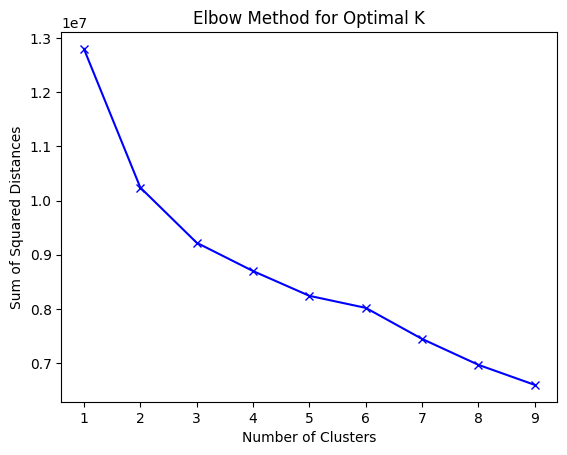

In [4]:
# Determine the optimal number of clusters using the elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
user_profiles_scaled = scaler.fit_transform(filtered_user_category_profiles)
sum_of_squared_distances = []
K = range(1, 10)  # Try more clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_profiles_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.show()


In [5]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

# Define data directory and file paths
data_dir = 'small/valid/'  # Adjust if your files are in a different directory
news_file = 'news.tsv'
valid_behaviors_file = 'behaviors.tsv'  # Validation behaviors file

# Load news data (if not already loaded)
news_path = os.path.join(data_dir, news_file)
news_df = pd.read_csv(
    news_path,
    sep='\t',
    names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'],
    index_col=False
)

print("Loaded news data:")
print(news_df.head())

# Load validation behaviors data
valid_behaviors_path = os.path.join(data_dir, valid_behaviors_file)
valid_behaviors_df = pd.read_csv(
    valid_behaviors_path,
    sep='\t',
    names=['ImpressionID', 'UserID', 'Time', 'HistoryText', 'Impressions'],
    index_col=False
)

print("\nLoaded validation behaviors data:")
print(valid_behaviors_df.head())
# Check for missing 'HistoryText' entries
missing_history = valid_behaviors_df['HistoryText'].isna().sum()
print(f"Number of entries with missing 'HistoryText': {missing_history}")
print(len(valid_behaviors_df['HistoryText']))
valid_behaviors_df['HistoryText'] = valid_behaviors_df['HistoryText'].fillna('')


Loaded news data:
   NewsID   Category      SubCategory  \
0  N55528  lifestyle  lifestyleroyals   
1  N18955     health          medical   
2  N61837       news        newsworld   
3  N53526     health           voices   
4  N38324     health          medical   

                                               Title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1  Dispose of unwanted prescription drugs during ...   
2  The Cost of Trump's Aid Freeze in the Trenches...   
3  I Was An NBA Wife. Here's How It Affected My M...   
4  How to Get Rid of Skin Tags, According to a De...   

                                            Abstract  \
0  Shop the notebooks, jackets, and more that the...   
1                                                NaN   
2  Lt. Ivan Molchanets peeked over a parapet of s...   
3  I felt like I was a fraud, and being an NBA wi...   
4  They seem harmless, but there's a very good re...   

                                             URL  \
0  https:

In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import pickle

# Load the user_category_profiles
user_category_profiles_path = 'user_category_profiles.pkl'
user_category_profiles = pd.read_pickle(user_category_profiles_path)

# --- [Perform Clustering] ---

# Optionally, standardize the features
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the user profiles
user_profiles_scaled = scaler.fit_transform(user_category_profiles)

# Save the scaler for future use
scaler_path = 'user_profiles_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")

# Initialize the clustering model
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the clustering model
kmeans.fit(user_profiles_scaled)

# Save the clustering model for future use
clustering_model_path = 'kmeans_user_clusters.pkl'
with open(clustering_model_path, 'wb') as f:
    pickle.dump(kmeans, f)
print(f"Saved KMeans clustering model to {clustering_model_path}")

# Assign clusters to users
user_clusters = kmeans.predict(user_profiles_scaled)

# Add the cluster assignments to the user profiles
user_category_profiles['Cluster'] = user_clusters

# Save the cluster assignments
user_cluster_df = user_category_profiles[['Cluster']]
user_cluster_df_path = 'user_cluster_df.pkl'
user_cluster_df.to_pickle(user_cluster_df_path)
print(f"Saved user cluster assignments to {user_cluster_df_path}")


Saved scaler to user_profiles_scaler.pkl
Saved KMeans clustering model to kmeans_user_clusters.pkl
Saved user cluster assignments to user_cluster_df.pkl


In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- [DataGenerator Class] ---
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, max_history_length, max_title_length):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.max_history_length = max_history_length
        self.max_title_length = max_title_length

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        if batch.empty:
            raise ValueError(f"Batch index {idx} is empty.")

        # Extract data
        history_tokens = batch['HistoryTokens'].tolist()  # List of lists of lists
        candidate_titles = batch['CandidateTitleTokens'].tolist()
        labels = batch['Label'].astype(np.float32).values  # Ensure labels are float32

        # Pad candidate titles
        candidate_titles_padded = pad_sequences(
            candidate_titles,
            maxlen=self.max_title_length,
            padding='post',
            truncating='post',
            value=0
        )

        # Initialize list to store padded histories
        history_padded_batch = []

        for user_history in history_tokens:
            # user_history is a list of lists (titles)
            if not user_history:
                # If user has no history, create a zero matrix
                padded_user_history = np.zeros((self.max_history_length, self.max_title_length), dtype=np.int32)
            else:
                # Pad each title in the history
                padded_titles = pad_sequences(
                    user_history,
                    maxlen=self.max_title_length,
                    padding='post',
                    truncating='post',
                    value=0
                )

                # Pad/truncate the history to max_history_length
                if len(padded_titles) < self.max_history_length:
                    pad_length = self.max_history_length - len(padded_titles)
                    # Create padding titles
                    pad_titles = np.zeros((pad_length, self.max_title_length), dtype=np.int32)
                    # Concatenate padded titles with padding titles
                    padded_user_history = np.vstack([padded_titles, pad_titles])
                else:
                    # Truncate to max_history_length
                    padded_user_history = padded_titles[:self.max_history_length]

            history_padded_batch.append(padded_user_history)

        # Convert list to numpy array
        history_padded_batch = np.array(history_padded_batch, dtype=np.int32)

        # Create a dictionary for inputs
        inputs = {
            'history_input': history_padded_batch,
            'candidate_input': candidate_titles_padded
        }

        return inputs, labels

# --- [Loading and Preparing Data] ---

# Load or initialize your tokenizer
tokenizer_path = 'tokenizer.pkl'
if os.path.exists(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print("\nLoaded existing tokenizer.")
else:
    # If not, initialize and fit a new tokenizer (not recommended if training was already done)
    tokenizer = Tokenizer(num_words=63346, oov_token='<OOV>')  # Adjust num_words as per your setup
    # Assuming 'news_df' is already loaded
    tokenizer.fit_on_texts(news_df['Title'])
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print("\nInitialized and fitted a new tokenizer.")

# Convert titles to sequences
news_df['TitleTokens'] = tokenizer.texts_to_sequences(news_df['Title'])

print("\nSample tokenized titles:")
print(news_df[['NewsID', 'Title', 'TitleTokens']].head())

# Create a mapping from NewsID to TitleTokens
newsid_to_tokens = dict(zip(news_df['NewsID'], news_df['TitleTokens']))

# Function to parse impressions and create labeled data
def parse_impressions(row):
    impressions = row['Impressions'].split(' ')
    history_titles = row['HistoryText'].split(' ') if isinstance(row['HistoryText'], str) else []
    data = []
    for impression in impressions:
        if '-' not in impression:
            continue  # Skip malformed impressions
        news_id, label = impression.split('-')
        title_tokens = newsid_to_tokens.get(news_id, [])
        data.append({
            'UserID': row['UserID'],
            'HistoryTitles': history_titles,  # List of NewsIDs
            'CandidateTitleTokens': title_tokens,
            'Label': int(label)
        })
    return data

# Apply the function to each row in the validation behaviors with a progress bar
test_data = []
for idx, row in tqdm(valid_behaviors_df.iterrows(), total=valid_behaviors_df.shape[0], desc="Processing behaviors"):
    parsed = parse_impressions(row)
    test_data.extend(parsed)

# Create a DataFrame from the test data
test_df = pd.DataFrame(test_data)

print("\nCreated test_df with samples:")
print(test_df.head())
print(f"\nTotal test samples: {len(test_df)}")

# Function to convert NewsIDs in history to token sequences
def convert_history(news_ids):
    return [newsid_to_tokens.get(news_id, []) for news_id in news_ids]

# Apply the function to convert history
test_df['HistoryTokens'] = test_df['HistoryTitles'].apply(convert_history)

print("\nSample HistoryTokens:")
print(test_df[['UserID', 'HistoryTitles', 'HistoryTokens']].head())

# --- [Loading Clustering Artifacts] ---

# Paths to clustering artifacts
user_cluster_path = 'user_cluster_df.pkl'
clustering_model_path = 'kmeans_user_clusters.pkl'
user_category_profiles_path = 'user_category_profiles.pkl'
scaler_path = 'user_profiles_scaler.pkl'

# Check if user_cluster_df.pkl exists
if os.path.exists(user_cluster_path):
    user_cluster_df = pd.read_pickle(user_cluster_path)
    print("\nLoaded user_cluster_df.")
else:
    print("\nuser_cluster_df.pkl not found. Recreating cluster assignments.")
    # Load the clustering model
    if os.path.exists(clustering_model_path):
        with open(clustering_model_path, 'rb') as f:
            clustering_model = pickle.load(f)
        print("\nLoaded clustering model.")
    else:
        print("Clustering model not found. Please ensure you have saved the clustering model during training.")
        raise FileNotFoundError("Clustering model not found.")

    # Load user_category_profiles
    if os.path.exists(user_category_profiles_path):
        user_category_profiles = pd.read_pickle(user_category_profiles_path)
        print("\nLoaded user_category_profiles.")
    else:
        print("user_category_profiles.pkl not found. Cannot proceed without user profiles.")
        raise FileNotFoundError("User profiles not found.")

    # Load scaler
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print("\nLoaded scaler for user profiles.")
    else:
        print("Scaler not found. Please ensure you have saved the scaler during training.")
        raise FileNotFoundError("Scaler not found.")

    # Ensure test users are included in user_category_profiles
    test_user_ids = test_df['UserID'].unique()
    missing_user_ids = set(test_user_ids) - set(user_category_profiles.index)
    if missing_user_ids:
        print(f"\nAdding {len(missing_user_ids)} new users to user_category_profiles.")
        new_user_profiles = pd.DataFrame(0, index=missing_user_ids, columns=user_category_profiles.columns)
        user_category_profiles = pd.concat([user_category_profiles, new_user_profiles])
        print("Added new user profiles for test users.")

    # Scale user profiles
    user_profiles_for_clustering = user_category_profiles.loc[test_user_ids]
    user_profiles_scaled = scaler.transform(user_profiles_for_clustering)

    # Assign clusters
    test_user_clusters = clustering_model.predict(user_profiles_scaled)

    # Create user_cluster_df with 'UserID' as index
    user_cluster_df = pd.DataFrame({
        'Cluster': test_user_clusters
    }, index=user_profiles_for_clustering.index)

    # Save the cluster assignments
    user_cluster_df.to_pickle('user_cluster_df.pkl')
    print("\nAssigned clusters to test users and saved to 'user_cluster_df.pkl'.")

# Display the first few rows
print(user_cluster_df.head())

# Check columns
print(user_cluster_df.columns)

# Check if 'UserID' is a column
if 'UserID' in user_cluster_df.columns:
    print("'UserID' is a column.")
else:
    print("'UserID' is not a column. It might be the index.")

# Map clusters to test_df
user_cluster_mapping = user_cluster_df['Cluster']  # Series with UserID as index

test_df['Cluster'] = test_df['UserID'].map(user_cluster_mapping)

# Handle users not found in user_cluster_df
missing_clusters = test_df['Cluster'].isna().sum()
if missing_clusters > 0:
    print(f"\nNumber of users without cluster assignment: {missing_clusters}")
    test_df['Cluster'] = test_df['Cluster'].fillna(0)  # Assign to Cluster 0 or any default cluster
    print("Assigned default cluster 0 to users without cluster assignment.")

print("\nAssigned clusters to test_df:")
print(test_df['Cluster'].value_counts())

# --- [Creating Test Data per Cluster] ---

# Define the number of clusters (ensure it matches your training)
num_clusters = 3  # Adjust as needed

# Initialize a dictionary to hold test data per cluster
cluster_test_data = {}
for cluster in range(num_clusters):
    cluster_data = test_df[test_df['Cluster'] == cluster].reset_index(drop=True)
    cluster_test_data[cluster] = cluster_data
    print(f"Cluster {cluster}: {len(cluster_data)} test samples.")

# Define maximum lengths (should match training)
max_history_length = 50
max_title_length = 30
batch_size = 64  # Adjust as needed

# Define a function to create TensorFlow Dataset with output_signature
def add_output_sig(datagen, max_history_length, max_title_length):
    output_signature = (
        {
            'history_input': tf.TensorSpec(shape=(None, max_history_length, max_title_length), dtype=tf.int32),
            'candidate_input': tf.TensorSpec(shape=(None, max_title_length), dtype=tf.int32),
        },
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
    
    # Define a generator function
    def generator():
        for i in range(len(datagen)):
            inputs, labels = datagen[i]
            
            # Assert non-empty inputs
            assert inputs['history_input'].shape[0] > 0, f"Batch {i} has empty history_input."
            assert inputs['candidate_input'].shape[0] > 0, f"Batch {i} has empty candidate_input."
            assert labels.shape[0] > 0, f"Batch {i} has empty labels."
            
            yield inputs, labels
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    # Optional optimizations
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Initialize test DataGenerators per cluster
test_generators = {}
for cluster in range(num_clusters):
    cluster_data = cluster_test_data[cluster]
    if cluster_data.empty:
        print(f"Cluster {cluster} has no test data. Skipping...")
        continue
    datagen = DataGenerator(
        df=cluster_data,
        batch_size=batch_size,
        max_history_length=max_history_length,
        max_title_length=max_title_length
    )
    test_generators[cluster] = add_output_sig(datagen, max_history_length, max_title_length)
    print(f"Created test_generator for Cluster {cluster}.")

# --- [Evaluating Models] ---

for cluster in range(num_clusters):
    print(f"\nEvaluating Model for Cluster {cluster}")
    
    model = models.get(cluster)  # Assuming 'models' is a dict with cluster as key
    if model is None:
        print(f"No model found for Cluster {cluster}. Skipping...")
        continue
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    # Evaluate the model
    try:
        results = model.evaluate(
            test_generator,
            verbose=1
        )
    except Exception as e:
        print(f"Error evaluating model for Cluster {cluster}: {e}")
        continue
    
    # Display results
    print(f"Test Metrics for Cluster {cluster}:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"  {metric_name}: {value:.4f}")

# --- [Generating Classification Reports] ---

for cluster in range(num_clusters):
    print(f"\nGenerating Classification Report for Cluster {cluster}")
    
    model = models.get(cluster)
    if model is None:
        print(f"No model found for Cluster {cluster}. Skipping...")
        continue
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    try:
        # Generate predictions
        predictions = model.predict(test_generator, verbose=1)
        predicted_labels = (predictions > 0.5).astype(int).flatten()
        
        # Retrieve true labels
        true_labels = cluster_test_data[cluster]['Label'].astype(np.float32).values
        
        # Classification Report
        report = classification_report(true_labels, predicted_labels, digits=4)
        print(f"Classification Report for Cluster {cluster}:\n{report}")
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Cluster {cluster}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print(f"Error generating report for Cluster {cluster}: {e}")
        continue



Loaded existing tokenizer.

Sample tokenized titles:
   NewsID                                              Title  \
0  N55528  The Brands Queen Elizabeth, Prince Charles, an...   
1  N18955  Dispose of unwanted prescription drugs during ...   
2  N61837  The Cost of Trump's Aid Freeze in the Trenches...   
3  N53526  I Was An NBA Wife. Here's How It Affected My M...   
4  N38324  How to Get Rid of Skin Tags, According to a De...   

                                         TitleTokens  
0  [3342, 2487, 1105, 1721, 1648, 1721, 6877, 14535]  
1              [13222, 9234, 4983, 2648, 79, 26, 29]  
2                     [1006, 1889, 3014, 14536, 701]  
3                        [518, 840, 2469, 1779, 164]  
4                 [20, 5752, 3762, 11289, 27, 23410]  


Processing behaviors: 100%|█████████████████████████████████████████████████████| 73152/73152 [00:35<00:00, 2068.39it/s]



Created test_df with samples:
   UserID                                      HistoryTitles  \
0  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   
1  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   
2  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   
3  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   
4  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   

                                CandidateTitleTokens  Label  
0           [246, 9230, 2452, 3978, 198, 3566, 3179]      0  
1  [4195, 2250, 342, 21, 671, 976, 1035, 780, 18,...      0  
2                  [2114, 2380, 2971, 20, 5062, 583]      1  
3      [10700, 318, 4152, 81, 210, 309, 22938, 5574]      0  
4                                    [653, 723, 147]      0  

Total test samples: 2740998

Sample HistoryTokens:
   UserID                                      HistoryTitles  \
0  U80234  [N55189, N46039, N51741, N53234, N11276, N264,...   
1  U80234  [N55189, N46039, N517

2024-12-07 17:41:54.963923: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 4 bytes spill stores, 4 bytes spill loads

2024-12-07 17:41:55.106324: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 16 bytes spill stores, 16 bytes spill loads

2024-12-07 17:41:55.124907: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 36 bytes spill stores, 36 bytes spill loads

2024-12-07 17:41:55.242299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 196 bytes spill stores, 168 bytes spill loads



1454/1454 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - AUC: 0.5954 - loss: 0.4521 - precision: 0.0666 - recall: 0.0511
Test Metrics for Cluster 0:
  loss: 0.4501
  compile_metrics: 0.0658

Evaluating Model for Cluster 1


2024-12-07 17:42:03.208322: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-07 17:42:03.208366: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-07 17:42:03.208684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2370515797060828571
2024-12-07 17:42:03.208714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16841741726712019017
2024-12-07 17:42:03.208734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14315849865906561681
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate a

     86/Unknown 10s 10ms/step - AUC: 0.5739 - loss: 0.6367 - precision: 0.0515 - recall: 0.1297

2024-12-07 17:42:14.356077: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 4 bytes spill stores, 4 bytes spill loads

2024-12-07 17:42:14.506937: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 16 bytes spill stores, 16 bytes spill loads

2024-12-07 17:42:14.516369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 36 bytes spill stores, 36 bytes spill loads

2024-12-07 17:42:14.628957: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_462', 196 bytes spill stores, 168 bytes spill loads



87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - AUC: 0.5738 - loss: 0.6367 - precision: 0.0515 - recall: 0.1300
Test Metrics for Cluster 1:
  loss: 0.6376
  compile_metrics: 0.0504

Evaluating Model for Cluster 2


2024-12-07 17:42:22.114351: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


  34546/Unknown 962s 28ms/step - AUC: 0.5925 - loss: 0.5957 - precision: 0.0688 - recall: 0.1910

In [1]:
model_weights = {0: 1.0, 1: 1.0, 2: 1.0}
from sklearn.metrics import roc_auc_score

cluster_validation_metrics = {}

def add_output_sig(datagen, max_history_length, max_title_length):
    output_signature = (
        {
            'history_input': tf.TensorSpec(shape=(None, max_history_length, max_title_length), dtype=tf.int32),
            'candidate_input': tf.TensorSpec(shape=(None, max_title_length), dtype=tf.int32),
        },
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
    
    # Define a generator function
    def generator():
        for i in range(len(datagen)):
            inputs, labels = datagen[i]
            
            # Assert non-empty inputs
            assert inputs['history_input'].shape[0] > 0, f"Batch {i} has empty history_input."
            assert inputs['candidate_input'].shape[0] > 0, f"Batch {i} has empty candidate_input."
            assert labels.shape[0] > 0, f"Batch {i} has empty labels."
            
            yield inputs, labels
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    # Optional optimizations
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset
test_generators = {}
for cluster in range(num_clusters):
    cluster_data = cluster_test_data[cluster]
    if cluster_data.empty:
        print(f"Cluster {cluster} has no test data. Skipping...")
        continue
    datagen = DataGenerator(
        df=cluster_data,
        batch_size=batch_size,
        max_history_length=max_history_length,
        max_title_length=max_title_length
    )
    test_generators[cluster] = add_output_sig(datagen, max_history_length, max_title_length)
    print(f"Created test_generator for Cluster {cluster}.")
for cluster in range(num_clusters):
    print(f"\nEvaluating Model for Cluster {cluster} on Validation Data")
    
    model = models.get(cluster)
    if model is None:
        print(f"No model found for Cluster {cluster}. Skipping...")
        continue
    # SHOULD THERE BE VALIDATION DATASET?????????
    test_generator = test_generators.get(cluster)  # Ensure you have validation_generators similar to test_generators
    if test_generator is None:
        print(f"No validation data available for Cluster {cluster}. Skipping...")
        continue
    
    # Generate predictions
    predictions = model.predict(test_generator, verbose=1)
    true_labels = cluster_test_data[cluster]['Label'].astype(np.float32).values
    # Compute AUC score
    auc = roc_auc_score(true_labels, predictions)
    cluster_validation_metrics[cluster] = auc
    print(f"Cluster {cluster} Validation AUC: {auc:.4f}")
# Extract AUC scores
auc_scores = np.array(list(cluster_validation_metrics.values()))
clusters = list(cluster_validation_metrics.keys())

# Normalize AUC scores to sum to 1
normalized_weights = auc_scores / np.sum(auc_scores)

# Map clusters to normalized weights
model_weights = dict(zip(clusters, normalized_weights))

print("\nModel Weights based on Validation AUC:")
for cluster, weight in model_weights.items():
    print(f"Cluster {cluster}: Weight = {weight:.4f}")
def recommend_news_weighted_averaging(models, model_weights, candidate_texts, history_texts, max_history_length=50, max_title_length=30):
    import numpy as np
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    # Prepare candidate input
    candidate_padded = pad_sequences(
        [candidate_texts],
        maxlen=max_title_length,
        padding='post',
        truncating='post',
        value=0
    )  # Shape: (1, max_title_length)

    # Prepare history input
    if len(history_texts) == 0:
        # If user has no history, create a zero matrix
        padded_user_history = np.zeros((max_history_length, max_title_length), dtype=np.int32)
    else:
        # Pad each title in the history to max_title_length
        padded_titles = pad_sequences(
            history_texts,  # Correct usage
            maxlen=max_title_length,
            padding='post',
            truncating='post',
            value=0
        )  # Shape: (num_titles_in_history, max_title_length)

        # Pad or truncate the history to max_history_length
        if len(padded_titles) < max_history_length:
            pad_length = max_history_length - len(padded_titles)
            # Create padding titles
            pad_titles = np.zeros((pad_length, max_title_length), dtype=np.int32)
            # Concatenate padded titles with padding titles
            padded_user_history = np.vstack([padded_titles, pad_titles])
        else:
            # Truncate to max_history_length
            padded_user_history = padded_titles[:max_history_length]

    # Add batch dimension
    history_padded = np.expand_dims(padded_user_history, axis=0)  # Shape: (1, max_history_length, max_title_length)

    inputs = {
        'history_input': history_padded,
        'candidate_input': candidate_padded
    }

    # Get weighted predictions
    weighted_sum = 0
    total_weight = sum(model_weights.values())

    for cluster, model in models.items():
        prediction = model.predict(inputs)[0][0]
        weight = model_weights.get(cluster, 1)
        weighted_sum += prediction * weight

    final_prediction = weighted_sum / total_weight

    return final_prediction

from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set your desired batch size
batch_size = 1024  # Adjust as needed

# Number of samples and batches
num_samples = len(test_df)
num_batches = int(np.ceil(num_samples / batch_size))

ensemble_true_labels = []
ensemble_predictions = []

print("\nEvaluating Weighted Averaging Ensemble Model in Batches")

for batch_idx in tqdm(range(num_batches), desc="Processing test batches"):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, num_samples)
    batch_df = test_df.iloc[start_idx:end_idx]

    candidate_texts_batch = batch_df['CandidateTitleTokens'].tolist()
    history_texts_batch = batch_df['HistoryTokens'].tolist()
    labels_batch = batch_df['Label'].tolist()

    # Prepare candidate inputs
    candidate_padded_batch = pad_sequences(
        candidate_texts_batch,
        maxlen=max_title_length,
        padding='post',
        truncating='post',
        value=0
    )  # Shape: (batch_size, max_title_length)

    # Prepare history inputs
    history_padded_batch = []
    for history_texts in history_texts_batch:
        if len(history_texts) == 0:
            # If user has no history, create a zero matrix
            padded_user_history = np.zeros((max_history_length, max_title_length), dtype=np.int32)
        else:
            # Pad each title in the history to max_title_length
            padded_titles = pad_sequences(
                history_texts,
                maxlen=max_title_length,
                padding='post',
                truncating='post',
                value=0
            )  # Shape: (num_titles_in_history, max_title_length)

            # Pad or truncate the history to max_history_length
            if len(padded_titles) < max_history_length:
                pad_length = max_history_length - len(padded_titles)
                # Create padding titles
                pad_titles = np.zeros((pad_length, max_title_length), dtype=np.int32)
                # Concatenate padded titles with padding titles
                padded_user_history = np.vstack([padded_titles, pad_titles])
            else:
                # Truncate to max_history_length
                padded_user_history = padded_titles[:max_history_length]

        history_padded_batch.append(padded_user_history)

    # Convert to numpy array
    history_padded_batch = np.array(history_padded_batch)  # Shape: (batch_size, max_history_length, max_title_length)

    inputs = {
        'history_input': history_padded_batch,
        'candidate_input': candidate_padded_batch
    }

    # Get weighted predictions
    total_weight = sum(model_weights.values())
    weighted_sum = np.zeros(len(batch_df))

    for cluster, model in models.items():
        # Suppress progress bar by setting verbose=0
        predictions = model.predict(inputs, verbose=0).flatten()
        weight = model_weights.get(cluster, 1)
        weighted_sum += predictions * weight

    final_predictions = weighted_sum / total_weight

    ensemble_true_labels.extend(labels_batch)
    ensemble_predictions.extend(final_predictions)

# After processing all batches, proceed with evaluation metrics as before

# Convert lists to numpy arrays
ensemble_true_labels = np.array(ensemble_true_labels)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_predicted_labels = (ensemble_predictions >= 0.5).astype(int)

# Compute metrics
auc = roc_auc_score(ensemble_true_labels, ensemble_predictions)
accuracy = accuracy_score(ensemble_true_labels, ensemble_predicted_labels)
precision = precision_score(ensemble_true_labels, ensemble_predicted_labels)
recall = recall_score(ensemble_true_labels, ensemble_predicted_labels)
f1 = f1_score(ensemble_true_labels, ensemble_predicted_labels)

print("\nWeighted Averaging Ensemble Model Performance:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
report = classification_report(ensemble_true_labels, ensemble_predicted_labels, digits=4)
print("\nClassification Report for Weighted Averaging Ensemble Model:\n", report)

# Confusion Matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Weighted Averaging Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Example: Collect individual model metrics
cluster_metrics = []

for cluster in range(num_clusters):
    # Retrieve true labels and predictions for each cluster
    true_labels = cluster_test_data[cluster]['Label'].astype(np.float32).values
    predictions = models[cluster].predict(test_generators[cluster]).flatten()
    predicted_labels = (predictions >= 0.5).astype(int)
    
    # Compute metrics
    auc_cluster = roc_auc_score(true_labels, predictions)
    accuracy_cluster = accuracy_score(true_labels, predicted_labels)
    precision_cluster = precision_score(true_labels, predicted_labels)
    recall_cluster = recall_score(true_labels, predicted_labels)
    f1_cluster = f1_score(true_labels, predicted_labels)
    
    cluster_metrics.append({
        'Model': f'Cluster {cluster} Model',
        'AUC': auc_cluster,
        'Accuracy': accuracy_cluster,
        'Precision': precision_cluster,
        'Recall': recall_cluster,
        'F1 Score': f1_cluster
    })

# Add ensemble model metrics
cluster_metrics.append({
    'Model': 'Weighted Averaging Ensemble',
    'AUC': auc,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Create DataFrame
performance_df = pd.DataFrame(cluster_metrics)

print("\nPerformance Comparison:")
print(performance_df)
import matplotlib.pyplot as plt

# Plot AUC scores
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='AUC', data=performance_df)
plt.title('AUC Score Comparison')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.show()

# Plot Accuracy scores
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', data=performance_df)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


NameError: name 'num_clusters' is not defined

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute metrics
auc = roc_auc_score(ensemble_true_labels, ensemble_predictions)
accuracy = accuracy_score(ensemble_true_labels, ensemble_predicted_labels)
precision = precision_score(ensemble_true_labels, ensemble_predicted_labels)
recall = recall_score(ensemble_true_labels, ensemble_predicted_labels)
f1 = f1_score(ensemble_true_labels, ensemble_predicted_labels)

print("\nWeighted Averaging Ensemble Model Performance:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
report = classification_report(ensemble_true_labels, ensemble_predicted_labels, digits=4)
print("\nClassification Report for Weighted Averaging Ensemble Model:\n", report)

# Confusion Matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Weighted Averaging Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Example: Collect individual model metrics
cluster_metrics = []

for cluster in range(num_clusters):
    # Retrieve true labels and predictions for each cluster
    true_labels = cluster_test_data[cluster]['Label'].astype(np.float32).values
    predictions = models[cluster].predict(test_generators[cluster]).flatten()
    predicted_labels = (predictions >= 0.5).astype(int)
    
    # Compute metrics
    auc_cluster = roc_auc_score(true_labels, predictions)
    accuracy_cluster = accuracy_score(true_labels, predicted_labels)
    precision_cluster = precision_score(true_labels, predicted_labels)
    recall_cluster = recall_score(true_labels, predicted_labels)
    f1_cluster = f1_score(true_labels, predicted_labels)
    
    cluster_metrics.append({
        'Model': f'Cluster {cluster} Model',
        'AUC': auc_cluster,
        'Accuracy': accuracy_cluster,
        'Precision': precision_cluster,
        'Recall': recall_cluster,
        'F1 Score': f1_cluster
    })

# Add ensemble model metrics
cluster_metrics.append({
    'Model': 'Weighted Averaging Ensemble',
    'AUC': auc,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Create DataFrame
performance_df = pd.DataFrame(cluster_metrics)

print("\nPerformance Comparison:")
print(performance_df)
import matplotlib.pyplot as plt

# Plot AUC scores
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='AUC', data=performance_df)
plt.title('AUC Score Comparison')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.show()

# Plot Accuracy scores
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', data=performance_df)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

for cluster in range(num_clusters):
    model = models[cluster]
    # Assuming 'model' is your Keras model
    #plot_model(model, to_file=f"model_architecture_{cluster}.png", show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))



In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, df, batch_size, max_history_length, max_title_length):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.max_history_length = max_history_length
        self.max_title_length = max_title_length

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Extract data
        history_tokens = batch['HistoryTokens'].tolist()  # List of lists of lists
        candidate_titles = batch['CandidateTitleTokens'].tolist()
        labels = batch['Label'].astype(np.float32).values  # Ensure labels are float32

        # Pad candidate titles
        candidate_titles_padded = pad_sequences(
            candidate_titles,
            maxlen=self.max_title_length,
            padding='post',
            truncating='post',
            value=0
        )

        # Initialize list to store padded histories
        history_padded_batch = []

        for user_history in history_tokens:
            # user_history is a list of lists (titles)
            if not user_history:
                # If user has no history, create a zero matrix
                padded_user_history = np.zeros((self.max_history_length, self.max_title_length), dtype=np.int32)
            else:
                # Pad each title in the history
                padded_titles = pad_sequences(
                    user_history,
                    maxlen=self.max_title_length,
                    padding='post',
                    truncating='post',
                    value=0
                )

                # Pad/truncate the history to max_history_length
                if len(padded_titles) < self.max_history_length:
                    pad_length = self.max_history_length - len(padded_titles)
                    # Create padding titles
                    pad_titles = np.zeros((pad_length, self.max_title_length), dtype=np.int32)
                    # Concatenate padded titles with padding titles
                    padded_user_history = np.vstack([padded_titles, pad_titles])
                else:
                    # Truncate to max_history_length
                    padded_user_history = padded_titles[:self.max_history_length]

            history_padded_batch.append(padded_user_history)

        # Convert list to numpy array
        history_padded_batch = np.array(history_padded_batch, dtype=np.int32)

        # Create a dictionary for inputs
        inputs = {
            'history_input': history_padded_batch,
            'candidate_input': candidate_titles_padded
        }

        return inputs, labels


# --- [Loading and Preparing Data] ---

# Load or initialize your tokenizer
tokenizer_path = 'tokenizer.pkl'
if os.path.exists(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print("\nLoaded existing tokenizer.")
else:
    # If not, initialize and fit a new tokenizer (not recommended if training was already done)
    tokenizer = Tokenizer(num_words=63346, oov_token='<OOV>')  # Adjust num_words as per your setup
    tokenizer.fit_on_texts(news_df['Title'])
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print("\nInitialized and fitted a new tokenizer.")

# Convert titles to sequences
news_df['TitleTokens'] = tokenizer.texts_to_sequences(news_df['Title'])

print("\nSample tokenized titles:")
print(news_df[['NewsID', 'Title', 'TitleTokens']].head())

# Create a mapping from NewsID to TitleTokens
newsid_to_tokens = dict(zip(news_df['NewsID'], news_df['TitleTokens']))

# Function to parse impressions and create labeled data
def parse_impressions(row):
    impressions = row['Impressions'].split(' ')
    history_titles = row['HistoryText'].split(' ') if isinstance(row['HistoryText'], str) else []
    data = []
    for impression in impressions:
        if '-' not in impression:
            continue  # Skip malformed impressions
        news_id, label = impression.split('-')
        title_tokens = newsid_to_tokens.get(news_id, [])
        data.append({
            'UserID': row['UserID'],
            'HistoryTitles': history_titles,  # List of NewsIDs
            'CandidateTitleTokens': title_tokens,
            'Label': int(label)
        })
    return data

# Apply the function to each row in the validation behaviors with a progress bar
test_data = []
for idx, row in tqdm(valid_behaviors_df.iterrows(), total=valid_behaviors_df.shape[0], desc="Processing behaviors"):
    parsed = parse_impressions(row)
    test_data.extend(parsed)

# Create a DataFrame from the test data
test_df = pd.DataFrame(test_data)

print("\nCreated test_df with samples:")
print(test_df.head())
print(f"\nTotal test samples: {len(test_df)}")

# Function to convert NewsIDs in history to token sequences
def convert_history(news_ids):
    return [newsid_to_tokens.get(news_id, []) for news_id in news_ids]

# Apply the function to convert history
test_df['HistoryTokens'] = test_df['HistoryTitles'].apply(convert_history)

print("\nSample HistoryTokens:")
print(test_df[['UserID', 'HistoryTitles', 'HistoryTokens']].head())

# --- [Loading Clustering Artifacts] ---

# Load user_cluster_df or recreate it
user_cluster_path = 'user_cluster_df.pkl'
clustering_model_path = 'kmeans_user_clusters.pkl'
user_category_profiles_path = 'user_category_profiles.pkl'
scaler_path = 'user_profiles_scaler.pkl'

# Check if user_cluster_df.pkl exists
if os.path.exists(user_cluster_path):
    user_cluster_df = pd.read_pickle(user_cluster_path)
    print("\nLoaded user_cluster_df.")
else:
    print("\nuser_cluster_df.pkl not found. Recreating cluster assignments.")
    
    # Load the clustering model
    if os.path.exists(clustering_model_path):
        with open(clustering_model_path, 'rb') as f:
            clustering_model = pickle.load(f)
        print("\nLoaded clustering model.")
    else:
        print("Clustering model not found. Please ensure you have saved the clustering model during training.")
        # Handle the error or exit
        raise FileNotFoundError("Clustering model not found.")
    
    # Load user_category_profiles
    if os.path.exists(user_category_profiles_path):
        user_category_profiles = pd.read_pickle(user_category_profiles_path)
        print("\nLoaded user_category_profiles.")
    else:
        print("user_category_profiles.pkl not found. Cannot proceed without user profiles.")
        raise FileNotFoundError("User profiles not found.")
    
    # Ensure test users are included in user_category_profiles
    test_user_ids = test_df['UserID'].unique()
    missing_user_ids = set(test_user_ids) - set(user_category_profiles.index)
    if missing_user_ids:
        print(f"\nAdding {len(missing_user_ids)} new users to user_category_profiles.")
        new_user_profiles = pd.DataFrame(0, index=missing_user_ids, columns=user_category_profiles.columns)
        user_category_profiles = user_category_profiles.append(new_user_profiles)
    
    # Load scaler
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print("\nLoaded scaler for user profiles.")
    else:
        print("Scaler not found. Please ensure you have saved the scaler during training.")
        raise FileNotFoundError("Scaler not found.")
    
    # Scale user profiles
    user_profiles_for_clustering = user_category_profiles.loc[test_user_ids]
    user_profiles_scaled = scaler.transform(user_profiles_for_clustering)
    
    # Assign clusters
    test_user_clusters = clustering_model.predict(user_profiles_scaled)
    
    # Create user_cluster_df
    user_cluster_df = pd.DataFrame({
        'UserID': user_profiles_for_clustering.index,
        'Cluster': test_user_clusters
    })
    user_cluster_df.to_pickle('user_cluster_df.pkl')
    print("\nAssigned clusters to test users and saved to 'user_cluster_df.pkl'.")

# Display the first few rows
print(user_cluster_df.head())

# Check columns
print(user_cluster_df.columns)

# Check if 'UserID' is a column
if 'UserID' in user_cluster_df.columns:
    print("'UserID' is a column.")
else:
    print("'UserID' is not a column. It might be the index.")
user_cluster_mapping = user_cluster_df['Cluster']

# Perform the mapping
test_df['Cluster'] = test_df['UserID'].map(user_cluster_mapping)

# Handle users not found in user_cluster_df
missing_clusters = test_df['Cluster'].isna().sum()
if missing_clusters > 0:
    print(f"\nNumber of users without cluster assignment: {missing_clusters}")
    test_df['Cluster'].fillna(0, inplace=True)  # Assign to Cluster 0 or any default cluster
    print("Assigned default cluster 0 to users without cluster assignment.")

print("\nAssigned clusters to test_df:")
print(test_df['Cluster'].value_counts())

# --- [Creating Test Data per Cluster] ---

# Initialize a dictionary to hold test data per cluster
cluster_test_data = {}
for cluster in range(num_clusters):
    cluster_data = test_df[test_df['Cluster'] == cluster].reset_index(drop=True)
    cluster_test_data[cluster] = cluster_data
    print(f"Cluster {cluster}: {len(cluster_data)} test samples.")

# Define maximum lengths (should match training)
max_history_length = 50
max_title_length = 30
batch_size = 64  # Adjust as needed
def add_output_sig(datagen):
    output_signature = (
        {
            'history_input': tf.TensorSpec(shape=(None, max_history_length, max_title_length), dtype=tf.int32),
            'candidate_input': tf.TensorSpec(shape=(None, max_title_length), dtype=tf.int32),
        },
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
    
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: datagen,
        output_signature=output_signature
    )
    dataset = dataset.repeat(1)

    # Optional caching and prefetching
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
# Initialize test DataGenerators per cluster
test_generators = {}
for cluster in range(num_clusters):
    cluster_data = cluster_test_data[cluster]
    if cluster_data.empty:
        print(f"Cluster {cluster} has no test data. Skipping...")
        continue
    test_generators[cluster] = add_output_sig(DataGenerator(
        df=cluster_data,
        batch_size=batch_size,
        max_history_length=max_history_length,
        max_title_length=max_title_length
    ))
    print(f"Created test_generator for Cluster {cluster}.")

# --- [Evaluating Models] ---

for cluster, model in models.items():
    print(f"\nEvaluating Model for Cluster {cluster}")
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    # Evaluate the model
    results = model.evaluate(
        test_generator,
        verbose=1
    )
    
    # Display results
    print(f"Test Metrics for Cluster {cluster}:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"  {metric_name}: {value:.4f}")

# --- [Generating Classification Reports] ---

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(models)
for cluster, model in models.items():
    print(f"\nGenerating Classification Report for Cluster {cluster}")
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    # Generate predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Retrieve true labels
    true_labels = cluster_test_data[cluster]['Label'].values
    
    # Classification Report
    report = classification_report(true_labels, predicted_labels, digits=4)
    print(f"Classification Report for Cluster {cluster}:\n{report}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Cluster {cluster}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- [Loading and Preparing Data] ---

# Load or initialize your tokenizer
tokenizer_path = 'tokenizer.pkl'
if os.path.exists(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print("\nLoaded existing tokenizer.")
else:
    # If not, initialize and fit a new tokenizer (not recommended if training was already done)
    tokenizer = Tokenizer(num_words=63346, oov_token='<OOV>')  # Adjust num_words as per your setup
    tokenizer.fit_on_texts(news_df['Title'])
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print("\nInitialized and fitted a new tokenizer.")

# Convert titles to sequences
news_df['TitleTokens'] = tokenizer.texts_to_sequences(news_df['Title'])

print("\nSample tokenized titles:")
print(news_df[['NewsID', 'Title', 'TitleTokens']].head())

# Create a mapping from NewsID to TitleTokens
newsid_to_tokens = dict(zip(news_df['NewsID'], news_df['TitleTokens']))

# Function to parse impressions and create labeled data
def parse_impressions(row):
    impressions = row['Impressions'].split(' ')
    history_titles = row['HistoryText'].split(' ') if isinstance(row['HistoryText'], str) else []
    data = []
    for impression in impressions:
        if '-' not in impression:
            continue  # Skip malformed impressions
        news_id, label = impression.split('-')
        title_tokens = newsid_to_tokens.get(news_id, [])
        data.append({
            'UserID': row['UserID'],
            'HistoryTitles': history_titles,  # List of NewsIDs
            'CandidateTitleTokens': title_tokens,
            'Label': int(label)
        })
    return data

# Apply the function to each row in the validation behaviors with a progress bar
test_data = []
for idx, row in tqdm(valid_behaviors_df.iterrows(), total=valid_behaviors_df.shape[0], desc="Processing behaviors"):
    parsed = parse_impressions(row)
    test_data.extend(parsed)

# Create a DataFrame from the test data
test_df = pd.DataFrame(test_data)

print("\nCreated test_df with samples:")
print(test_df.head())
print(f"\nTotal test samples: {len(test_df)}")

# Function to convert NewsIDs in history to token sequences
def convert_history(news_ids):
    return [newsid_to_tokens.get(news_id, []) for news_id in news_ids]

# Apply the function to convert history
test_df['HistoryTokens'] = test_df['HistoryTitles'].apply(convert_history)

print("\nSample HistoryTokens:")
print(test_df[['UserID', 'HistoryTitles', 'HistoryTokens']].head())

# --- [Loading Clustering Artifacts] ---

# Paths to clustering artifacts
user_cluster_path = 'user_cluster_df.pkl'
clustering_model_path = 'kmeans_user_clusters.pkl'
user_category_profiles_path = 'user_category_profiles.pkl'
scaler_path = 'user_profiles_scaler.pkl'

# Check if user_cluster_df.pkl exists
if os.path.exists(user_cluster_path):
    user_cluster_df = pd.read_pickle(user_cluster_path)
    print("\nLoaded user_cluster_df.")
else:
    print("\nuser_cluster_df.pkl not found. Recreating cluster assignments.")
    # Load the clustering model
    if os.path.exists(clustering_model_path):
        with open(clustering_model_path, 'rb') as f:
            clustering_model = pickle.load(f)
        print("\nLoaded clustering model.")
    else:
        print("Clustering model not found. Please ensure you have saved the clustering model during training.")
        raise FileNotFoundError("Clustering model not found.")
    
    # Load user_category_profiles
    if os.path.exists(user_category_profiles_path):
        user_category_profiles = pd.read_pickle(user_category_profiles_path)
        print("\nLoaded user_category_profiles.")
    else:
        print("user_category_profiles.pkl not found. Cannot proceed without user profiles.")
        raise FileNotFoundError("User profiles not found.")
    
    # Load scaler
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print("\nLoaded scaler for user profiles.")
    else:
        print("Scaler not found. Please ensure you have saved the scaler during training.")
        raise FileNotFoundError("Scaler not found.")
    
    # Ensure test users are included in user_category_profiles
    test_user_ids = test_df['UserID'].unique()
    missing_user_ids = set(test_user_ids) - set(user_category_profiles.index)
    if missing_user_ids:
        print(f"\nAdding {len(missing_user_ids)} new users to user_category_profiles.")
        new_user_profiles = pd.DataFrame(0, index=missing_user_ids, columns=user_category_profiles.columns)
        user_category_profiles = pd.concat([user_category_profiles, new_user_profiles])
        print("Added new user profiles for test users.")
    
    # Scale user profiles
    user_profiles_for_clustering = user_category_profiles.loc[test_user_ids]
    user_profiles_scaled = scaler.transform(user_profiles_for_clustering)
    
    # Assign clusters
    test_user_clusters = clustering_model.predict(user_profiles_scaled)
    
    # Create user_cluster_df with 'UserID' as index
    user_cluster_df = pd.DataFrame({
        'Cluster': test_user_clusters
    }, index=user_profiles_for_clustering.index)
    
    # Save the cluster assignments
    user_cluster_df.to_pickle('user_cluster_df.pkl')
    print("\nAssigned clusters to test users and saved to 'user_cluster_df.pkl'.")

# Map clusters to test_df
# Since 'UserID' is the index, access 'Cluster' directly
user_cluster_mapping = user_cluster_df['Cluster']  # Series with UserID as index

# Perform the mapping
test_df['Cluster'] = test_df['UserID'].map(user_cluster_mapping)

# Handle users not found in user_cluster_df
missing_clusters = test_df['Cluster'].isna().sum()
if missing_clusters > 0:
    print(f"\nNumber of users without cluster assignment: {missing_clusters}")
    # Replace the following line to avoid FutureWarning
    test_df['Cluster'] = test_df['Cluster'].fillna(0)  # Assign to Cluster 0 or any default cluster
    print("Assigned default cluster 0 to users without cluster assignment.")

print("\nAssigned clusters to test_df:")
print(test_df['Cluster'].value_counts())

# --- [Creating Test Data per Cluster] ---

# Define the number of clusters (ensure it matches your training)
num_clusters = 3  # Adjust as needed

# Initialize a dictionary to hold test data per cluster
cluster_test_data = {}
for cluster in range(num_clusters):
    cluster_data = test_df[test_df['Cluster'] == cluster].reset_index(drop=True)
    cluster_test_data[cluster] = cluster_data
    print(f"Cluster {cluster}: {len(cluster_data)} test samples.")

# Define maximum lengths (should match training)
max_history_length = 50
max_title_length = 30
batch_size = 64  # Adjust as needed

# Define your DataGenerator class (ensure it's correctly implemented)
# Example:
# class DataGenerator(Sequence):
#     ...

# Initialize test DataGenerators per cluster
test_generators = {}
for cluster in range(num_clusters):
    cluster_data = cluster_test_data[cluster]
    if cluster_data.empty:
        print(f"Cluster {cluster} has no test data. Skipping...")
        continue
    test_generators[cluster] = add_output_sig(DataGenerator(
        df=cluster_data,
        batch_size=batch_size,
        max_history_length=max_history_length,
        max_title_length=max_title_length
    ))
    print(f"Created test_generator for Cluster {cluster}.")

# --- [Evaluating Models] ---

for cluster, model in models.items():
    print(f"\nEvaluating Model for Cluster {cluster}")
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    # Evaluate the model
    try:
        results = model.evaluate(
            test_generator,
            verbose=1
        )
    except Exception as e:
        print(f"Error evaluating model for Cluster {cluster}: {e}")
        continue
    
    # Display results
    print(f"Test Metrics for Cluster {cluster}:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"  {metric_name}: {value:.4f}")

# --- [Generating Classification Reports] ---

for cluster, model in models.items():
    print(f"\nGenerating Classification Report for Cluster {cluster}")
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        print(f"No test data available for Cluster {cluster}. Skipping...")
        continue
    
    try:
        # Generate predictions
        predictions = model.predict(test_generator, verbose=1)
        predicted_labels = (predictions > 0.5).astype(int).flatten()
        
        # Retrieve true labels
        true_labels = cluster_test_data[cluster]['Label'].values
        
        # Classification Report
        report = classification_report(true_labels, predicted_labels, digits=4)
        print(f"Classification Report for Cluster {cluster}:\n{report}")
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Cluster {cluster}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print(f"Error generating report for Cluster {cluster}: {e}")
        continue


In [ ]:
# Assuming you have access to training and validation logs
for cluster in range(num_clusters):
    # Load training and validation logs
    train_log_path = f'training_log_cluster_{cluster}.csv'
    try:
        train_log_df = pd.read_csv(train_log_path)
    except FileNotFoundError:
        print(f"Training log for Cluster {cluster} not found. Skipping...")
        continue
    
    # Get the last epoch metrics
    train_auc = train_log_df['AUC'].iloc[-1]
    val_auc = train_log_df['val_AUC'].iloc[-1]
    
    # Retrieve test AUC
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        test_auc = None
    else:
        results = model.evaluate(test_generator, verbose=0)
        test_auc = results[model.metrics_names.index('AUC')]
    
    print(f"\nCluster {cluster} Metrics:")
    print(f"  Training AUC: {train_auc:.4f}")
    print(f"  Validation AUC: {val_auc:.4f}")
    if test_auc is not None:
        print(f"  Test AUC: {test_auc:.4f}")
    else:
        print("  Test AUC: Not Available")
import seaborn as sns

for cluster, model in models.items():
    print(f"\nVisualizing Prediction Distribution for Cluster {cluster}")
    
    test_generator = test_generators.get(cluster)
    if test_generator is None:
        continue
    
    predictions = model.predict(test_generator, verbose=1).flatten()
    true_labels = test_test_data[cluster]['Label'].values
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(predictions[true_labels == 1], shade=True, label='Positive Label')
    sns.kdeplot(predictions[true_labels == 0], shade=True, label='Negative Label')
    plt.title(f'Prediction Score Distribution for Cluster {cluster}')
    plt.xlabel('Predicted Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
# Example: Modify your model to output attention weights (if not already done)
# Assuming your model is built to return attention weights

# Create a separate model for attention extraction
attention_model = Model(
    inputs=model.input,
    outputs=[model.get_layer('user_encoder').output[1], model.get_layer('news_encoder').output[1]]  # Adjust layer names as needed
)

# Select a sample from the test set
sample = test_df.iloc[0]
history_tokens = convert_history(sample['HistoryTitles'])
candidate_tokens = sample['CandidateTitleTokens']

# Prepare input
history_padded = pad_sequences(
    [history_tokens],
    maxlen=max_history_length,
    padding='post',
    truncating='post',
    value=0
)
candidate_padded = pad_sequences(
    [candidate_tokens],
    maxlen=max_title_length,
    padding='post',
    truncating='post',
    value=0
)

inputs = {
    'history_input': np.array(history_padded),
    'candidate_input': np.array(candidate_padded)
}

# Get attention weights
user_attention, candidate_attention = attention_model.predict(inputs)

# Visualize attention weights
plt.figure(figsize=(10, 2))
sns.heatmap(user_attention, annot=False, cmap='viridis', cbar=False)
plt.title('User History Attention Weights')
plt.xlabel('History Sequence')
plt.show()

plt.figure(figsize=(10, 2))
sns.heatmap(candidate_attention, annot=False, cmap='viridis', cbar=False)
plt.title('Candidate News Attention Weights')
plt.xlabel('Candidate Sequence')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_batches(df, batch_size):
    while True:
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the data
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df.iloc[start:end]
            # Prepare inputs
            history_batch = []
            candidate_batch = []
            labels_batch = []
            for idx, row in batch_df.iterrows():
                history_titles = row['HistoryTitles']  # Use the tokenized titles
                # Pad each title in history
                history_titles_padded = pad_sequences(history_titles, maxlen=max_title_length, padding='post', truncating='post', value=0)
                # Pad or truncate the history to max_history_length
                if len(history_titles_padded) < max_history_length:
                    padding = np.zeros((max_history_length - len(history_titles_padded), max_title_length), dtype='int32')
                    history_titles_padded = np.vstack([padding, history_titles_padded])
                else:
                    history_titles_padded = history_titles_padded[-max_history_length:]
                candidate_title = row['CandidateTitleTokens']
                candidate_title_padded = pad_sequences([candidate_title], maxlen=max_title_length, padding='post', truncating='post', value=0)[0]
                history_batch.append(history_titles_padded)
                candidate_batch.append(candidate_title_padded)
                labels_batch.append(row['Label'])
            yield [np.array(history_batch), np.array(candidate_batch)], np.array(labels_batch)
# Assuming you have a test set prepared similarly
test_generator = generate_batches(test_df, batch_size)
test_steps = len(test_df) // batch_size
# Evaluate using model.evaluate()
evaluation = model.evaluate(test_generator, steps=test_steps)

# Or compute metrics manually
all_labels = []
all_preds = []
for [history_batch, candidate_batch], labels_batch in test_generator:
    preds = model.predict([history_batch, candidate_batch])
    all_labels.extend(labels_batch)
    all_preds.extend(preds)
    if len(all_labels) >= len(test_df):
        break
all_labels = all_labels[:len(test_df)]
all_preds = all_preds[:len(test_df)]
# Compute AUC
auc = roc_auc_score(all_labels, all_preds)
print(f'Test AUC: {auc:.4f}')